In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

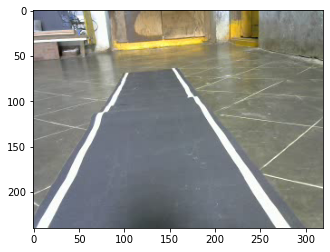

In [2]:
# capture = cv2.VideoCapture('test1.mp4')
# ret, frame = capture.read()
frame = cv2.imread('snapshots/bwd_1.png')
frame1 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame1)

## Canny Edge detection

In [3]:
def canny(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Reduce the color space
    # Smooth out the sharp edges -- so as to avoid detect all erroneous edges
    kernel = (5, 5)
    blur_img = cv2.GaussianBlur(gray_img, kernel, 0)
    # Now, detect the edges.
    canny_img = cv2.Canny(blur_img, 50, 150) ################################ !!!!!!!!!!!!!!!!!!!!!! Playable values
    return canny_img

In [4]:
def region_of_interest(img):
    height = img.shape[0]
    width = img.shape[1]
    # Create a mask like the clone of of `img`.
    mask = np.zeros_like(img)
    # Define the triangle points -- the area of interst.
    triangle = np.array([[(2, 212), (126, 20), (316, 216)]], np.int32)
    # Now fill the above created `mask` with white in the `triangle` region
    cv2.fillPoly(mask, triangle, 255)
    # Now get only the region of interest -- from the image.
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

In [5]:
def get_houghLines(img):
    """
    motivation: as humans, by seeing the road lanes image, can tell, where they are going towards. 
    But, the same for a computer -- just a set of pixels.
    This funciton helps in resolving that.
    Based on analysing the pattern of the pixels, approximates the direction, to where they are going.
    """
    houghLines = cv2.HoughLinesP(image=img, rho=2, theta=np.pi/180, threshold=100, lines=np.array([]), minLineLength=40, maxLineGap=5)
    return houghLines

In [6]:
def draw_houghLines(img, houghlines):
#     drawn_image = np.zeros_like(img)
    if houghlines is not None:
        for line in houghlines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return img

In [7]:
height = img.shape[1]
width = img.shape[0]
print(img.shape)
triangle = np.array([[(2, 212), (126, 20), (316, 216)]], np.int32)

roi_test_img = frame
for pt in triangle[0]:
    print(pt)
    cv2.circle(roi_test_img, pt, 15, (255, 255, 0), -1)

roi_test_img = cv2.cvtColor(roi_test_img, cv2.COLOR_BGR2RGB)
plt.imshow(roi_test_img)

NameError: name 'img' is not defined

In [8]:
# Apply canny edge detection
img = canny(frame)
# Remove the clutter
roi_img = region_of_interest(img)
# Get the hough lines
houghlines = get_houghLines(roi_img)
# Draw the hough lines on the image
# houglined_img = draw_houghLines(frame, houghlines)
# plt.imshow(houglined_img)

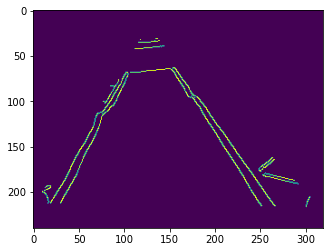

In [46]:
plt.imshow(roi_img)

----------------- end of part_1
<hr>
Steps done till now:
1. Canny Edge detection
2. Getting the region of interest (RoI)
3. Hough line transformation

Here, we could able to detect the lanes, but **multiple such**.
In next, will be resolving that.
<hr>
-- start of part_2

### How to resolve multiple lines?
- via **average slope intercept** concept.
    - i.e., 

In [9]:
def get_lane_coordinates(img, line):
    """
    @param img:
    @param line (slope, intercept):
    
    Notes
    Look the resource of TDS blog.
    """
    slope, intercept = line
    height, width = img.shape
    ## Assumptions taking..
    y1 = int(height) # y1 at the bottom
    y2 = int(y1*3.0/5)  # y2 -- some where between top and bottom
    # now from `y=mx+c`, x1 and x2 are calculated.
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    
    # done.
    return [[x1, y1, x2, y2]]

In [10]:
def get_avg_slope_intercepts(img, lines):
    """
    @brief takes the `lines` (houghlines) - classifies into left_lane and right_line.
    then performs average on those.
    Which yields in single line at both sides.
    
    Notes
    - np.polyfit() takes the co-ordinates -- analyzes and gives certain parameters describing it.
        in this case, its a line(deg=1), those parameters will be **slope** and **intercept**
    - if the slope is -ve - classify as left_lane,
                      +ve               right_lane
        figure out how... RayanSlim - PgmngKnowledge - did work on it.
    """
    ## classify the set of given lines into two classes
    left_fit = []
    right_fit = []
#     print(lines)
    for line in lines:
#         print(line[0])
        x1, y1, x2, y2 = line[0]
        slope, intercept = np.polyfit(x=(x1, x2), y=(y1, y2), deg=1)
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    
    # Now, find the average..
    left_fit_avg = np.average(left_fit, axis=0)
    right_fit_avg = np.average(right_fit, axis=0)
    
    # Now had averages of `slope` and `intercept` of either sides.
    # - but, we can't draw line based on `m` and `c`.
    # - so, get the co-ordinates based on these.
    left_lane = get_lane_coordinates(img, left_fit_avg)
    right_lane = get_lane_coordinates(img, right_fit_avg)
    
    # done..!! return the results
    return [left_lane, right_lane]

In [11]:
def draw_final_lanes(img, lanes):
    if lanes is not None:
        for lane in lanes:
            print(lane)
            x1, y1, x2, y2 = lane[0]
            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 10)
    return img

[[4, 240, 57, 144]]
[[279, 240, 212, 144]]


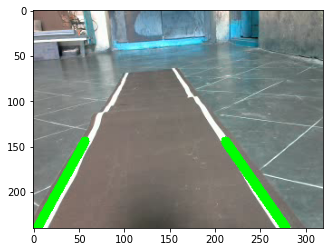

In [12]:
# Get the single left and right lane co-ordinates
road_lanes = get_avg_slope_intercepts(img, houghlines)
# Draw the final lanes.
img = draw_final_lanes(frame, road_lanes)
plt.imshow(img)

# Summary
## Steps followed
1. Canny Edge detection
2. Extracting the Region of Interest (RoI)
3. Applying Hough transform
4. Classify the houglines into left lane and right line
5. Find the average of left_lane and right_lane

Draw the calculated lane on the image to show

# Limitations
- Assumed that, `y1` and `y_2` are at the bottom -- that may not be the case always.
- When making turns or moving away to different lanes..

then this algorithm doesn't work.

This can't be used in real-world due to limitations.<br/>
But, definately, this algorithm creates a good understanding - in how, lanes are detected. 

# References
### Video Tutorial
- [Part_1]
- [Part_2](https://youtu.be/NWyHEpG4EVA)
### Blog
1. [Towards data science blog](https://towardsdatascience.com/a-deep-dive-into-lane-detection-with-hough-transform-8f90fdd1322f) -- based on the video watched earlier - RayanSlim - Programming Knowledge.

In [13]:
!python SimpleLaneDetector.py

[[-554, 720, -229, 432]]
[[887, 720, 551, 432]]
QObject::moveToThread: Current thread (0x55663daecfd0) is not the object's thread (0x55663ea6c000).
Cannot move to target thread (0x55663daecfd0)

QObject::moveToThread: Current thread (0x55663daecfd0) is not the object's thread (0x55663ea6c000).
Cannot move to target thread (0x55663daecfd0)

QObject::moveToThread: Current thread (0x55663daecfd0) is not the object's thread (0x55663ea6c000).
Cannot move to target thread (0x55663daecfd0)

QObject::moveToThread: Current thread (0x55663daecfd0) is not the object's thread (0x55663ea6c000).
Cannot move to target thread (0x55663daecfd0)

QObject::moveToThread: Current thread (0x55663daecfd0) is not the object's thread (0x55663ea6c000).
Cannot move to target thread (0x55663daecfd0)

QObject::moveToThread: Current thread (0x55663daecfd0) is not the object's thread (0x55663ea6c000).
Cannot move to target thread (0x55663daecfd0)

QObject::moveToThread: Current thread (0x55663daecfd0) is not the obje